# 利用GAN生成MNIST-demo

本篇代码将使用GAN来学习MNIST数据集的生成，仅仅作为一个demo演示，后面会更新更加复杂的GAN模型

In [1]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

# 导入数据

In [3]:
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets('/MNIST_data/')
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

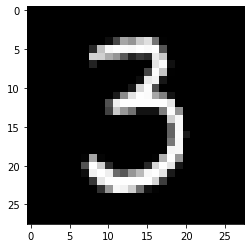

In [4]:
img = X_train[50]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

# 构建模型

- inputs
- generator
- descriminator
- loss && optimizer

## Inputs

In [5]:
def get_inputs(real_size, noise_size):
    """
    真实图像tensor与噪声图像tensor
    """
    real_img = tf.placeholder(tf.float32, [None, real_size], name='real_img')
    noise_img = tf.placeholder(tf.float32, [None, noise_size], name='noise_img')
    
    return real_img, noise_img

## generator

In [6]:
def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
    """
    生成器
    
    noise_img: 生成器的输入
    n_units: 隐层单元个数
    out_dim: 生成器输出tensor的size，这里应该为32*32=784
    alpha: leaky ReLU系数
    """
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # dropout
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)

        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

## Discriminator

In [7]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    """
    判别器
    
    n_units: 隐层结点数量
    alpha: Leaky ReLU系数
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

## 定义参数

In [18]:
# 定义参数
# 真实图像的size
# img_size = X_train[0].shape[0]
img_size = 784
# 传入给generator的噪声size
noise_size = 100
# 生成器隐层参数
g_units = 128
# 判别器隐层参数
d_units = 128
# leaky ReLU的参数
alpha = 0.01
# learning_rate
learning_rate = 0.001
# label smoothing
smooth = 0.1

## 构建网络

In [19]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

# generator
g_logits, g_outputs = get_generator(noise_img, g_units, img_size)

# discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)

## Loss

这里简单说一下Loss的计算方式，由于我们上面构建了两个神经网络：generator和discriminator，因此需要分别计算loss。

- discriminator
discriminator的目的在于对于给定的真图片，识别为真（1），对于generator生成的图片，识别为假（0），因此它的loss包含了真实图片的loss和生成器图片的loss两部分。

- generator
generator的目的在于让discriminator识别不出它的图片是假的，如果用1代表真，0代表假，那么generator生成的图片经过discriminator后要输出为1，因为generator想要骗过discriminator。

In [20]:
# discriminator的loss
# 识别真实图片
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)) * (1 - smooth))
# 识别生成的图片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_logits_fake)))
# 总体loss
d_loss = tf.add(d_loss_real, d_loss_fake)

# generator的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)) * (1 - smooth))

## Optimizer

由于我们在GAN里面一共训练了两个网络，所以需要分别定义优化函数。

In [21]:
train_vars = tf.trainable_variables()

# generator中的tensor
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator中的tensor
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

# 训练

In [22]:
# batch_size
batch_size = 64
# 训练迭代轮数
epochs = 300
# 抽取样本数
n_sample = 25

# 存储测试样例
samples = []
# 存储loss
losses = []
# 保存生成器变量
saver = tf.train.Saver(var_list = g_vars)
# 开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for step in range(X_train.shape[0]//batch_size):
            batch_index = step * batch_size % X_train.shape[0]
            batch_index = min(batch_index, X_train.shape[0] - batch_size)
            batch = X_train[batch_index:(batch_index + batch_size)]
            
#             batch = mnist.train.next_batch(batch_size)
            
#             batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch.reshape((batch_size, 784))
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
#             batch_images = batch_images*2 - 1
            batch_images = batch_images/255.0 * 2 - 1
            
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            _ = sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        train_loss_d = sess.run(d_loss, 
                                feed_dict = {real_img: batch_images, 
                                             noise_img: batch_noise})
        # real img loss
        train_loss_d_real = sess.run(d_loss_real, 
                                     feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake, 
                                    feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss, 
                                feed_dict = {noise_img: batch_noise})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}(Real: {:.4f} + Fake: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # 记录各类loss值
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # 抽取样本后期进行观察
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        # 存储checkpoints
        saver.save(sess, './checkpoints/generator.ckpt')

# 将sample的生成数据记录下来
with open('train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

Epoch 1/300... Discriminator Loss: 0.1342(Real: 0.0382 + Fake: 0.0959)... Generator Loss: 2.7345
Epoch 2/300... Discriminator Loss: 0.5645(Real: 0.1304 + Fake: 0.4341)... Generator Loss: 5.1571
Epoch 3/300... Discriminator Loss: 3.0610(Real: 0.8782 + Fake: 2.1827)... Generator Loss: 1.0841
Epoch 4/300... Discriminator Loss: 2.8162(Real: 1.0990 + Fake: 1.7173)... Generator Loss: 0.3404
Epoch 5/300... Discriminator Loss: 3.4241(Real: 1.5410 + Fake: 1.8832)... Generator Loss: 0.4583
Epoch 6/300... Discriminator Loss: 1.0298(Real: 0.3564 + Fake: 0.6734)... Generator Loss: 1.1305
Epoch 7/300... Discriminator Loss: 2.9396(Real: 0.1676 + Fake: 2.7720)... Generator Loss: 0.4520
Epoch 8/300... Discriminator Loss: 2.3743(Real: 1.6007 + Fake: 0.7736)... Generator Loss: 0.6942
Epoch 9/300... Discriminator Loss: 0.5809(Real: 0.1520 + Fake: 0.4288)... Generator Loss: 1.3010
Epoch 10/300... Discriminator Loss: 1.2885(Real: 0.9564 + Fake: 0.3321)... Generator Loss: 1.3460
Epoch 11/300... Discriminator

Epoch 85/300... Discriminator Loss: 0.9654(Real: 0.3443 + Fake: 0.6211)... Generator Loss: 1.1036
Epoch 86/300... Discriminator Loss: 0.8056(Real: 0.2588 + Fake: 0.5468)... Generator Loss: 1.2280
Epoch 87/300... Discriminator Loss: 0.7716(Real: 0.1808 + Fake: 0.5908)... Generator Loss: 1.0770
Epoch 88/300... Discriminator Loss: 0.6951(Real: 0.2331 + Fake: 0.4620)... Generator Loss: 1.3961
Epoch 89/300... Discriminator Loss: 0.6589(Real: 0.2216 + Fake: 0.4373)... Generator Loss: 1.4677
Epoch 90/300... Discriminator Loss: 0.9237(Real: 0.3157 + Fake: 0.6079)... Generator Loss: 1.0869
Epoch 91/300... Discriminator Loss: 0.8475(Real: 0.2779 + Fake: 0.5696)... Generator Loss: 1.2333
Epoch 92/300... Discriminator Loss: 0.8173(Real: 0.3289 + Fake: 0.4885)... Generator Loss: 1.4646
Epoch 93/300... Discriminator Loss: 0.8293(Real: 0.3892 + Fake: 0.4401)... Generator Loss: 1.4700
Epoch 94/300... Discriminator Loss: 0.9813(Real: 0.4878 + Fake: 0.4935)... Generator Loss: 1.2271
Epoch 95/300... Disc

Epoch 168/300... Discriminator Loss: 0.7445(Real: 0.2188 + Fake: 0.5258)... Generator Loss: 1.3103
Epoch 169/300... Discriminator Loss: 0.8028(Real: 0.2637 + Fake: 0.5392)... Generator Loss: 1.2363
Epoch 170/300... Discriminator Loss: 0.8191(Real: 0.3060 + Fake: 0.5130)... Generator Loss: 1.3487
Epoch 171/300... Discriminator Loss: 0.7308(Real: 0.3242 + Fake: 0.4066)... Generator Loss: 1.6588
Epoch 172/300... Discriminator Loss: 0.8341(Real: 0.2650 + Fake: 0.5691)... Generator Loss: 1.3087
Epoch 173/300... Discriminator Loss: 0.9367(Real: 0.2724 + Fake: 0.6643)... Generator Loss: 1.0876
Epoch 174/300... Discriminator Loss: 0.8643(Real: 0.2824 + Fake: 0.5819)... Generator Loss: 1.4192
Epoch 175/300... Discriminator Loss: 0.8626(Real: 0.3518 + Fake: 0.5108)... Generator Loss: 1.5909
Epoch 176/300... Discriminator Loss: 0.9439(Real: 0.2887 + Fake: 0.6552)... Generator Loss: 1.2271
Epoch 177/300... Discriminator Loss: 0.7709(Real: 0.3843 + Fake: 0.3866)... Generator Loss: 1.7933
Epoch 178/

Epoch 251/300... Discriminator Loss: 0.5548(Real: 0.2363 + Fake: 0.3185)... Generator Loss: 1.5560
Epoch 252/300... Discriminator Loss: 0.6012(Real: 0.3145 + Fake: 0.2866)... Generator Loss: 1.9914
Epoch 253/300... Discriminator Loss: 0.7538(Real: 0.4004 + Fake: 0.3534)... Generator Loss: 1.7754
Epoch 254/300... Discriminator Loss: 0.5897(Real: 0.2692 + Fake: 0.3205)... Generator Loss: 1.8285
Epoch 255/300... Discriminator Loss: 0.8193(Real: 0.3353 + Fake: 0.4840)... Generator Loss: 1.5880
Epoch 256/300... Discriminator Loss: 0.5415(Real: 0.2170 + Fake: 0.3245)... Generator Loss: 1.8479
Epoch 257/300... Discriminator Loss: 0.6582(Real: 0.2594 + Fake: 0.3989)... Generator Loss: 1.6822
Epoch 258/300... Discriminator Loss: 0.8225(Real: 0.2340 + Fake: 0.5886)... Generator Loss: 1.2143
Epoch 259/300... Discriminator Loss: 0.7211(Real: 0.3197 + Fake: 0.4014)... Generator Loss: 1.6569
Epoch 260/300... Discriminator Loss: 0.7625(Real: 0.3576 + Fake: 0.4049)... Generator Loss: 1.5303
Epoch 261/

# 绘制loss曲线

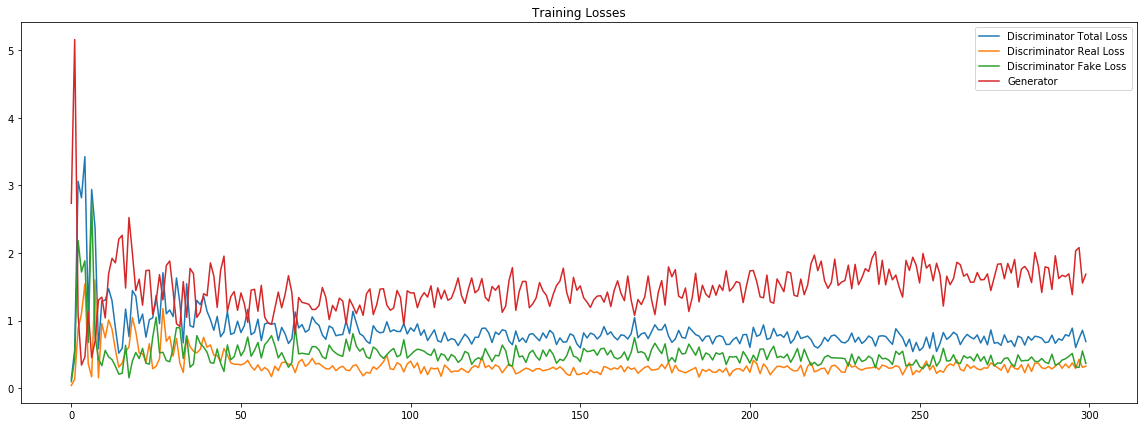

In [23]:
fig, ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator Total Loss')
plt.plot(losses.T[1], label='Discriminator Real Loss')
plt.plot(losses.T[2], label='Discriminator Fake Loss')
plt.plot(losses.T[3], label='Generator')
plt.title("Training Losses")
plt.legend()

# 显示图像

In [24]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)

In [25]:
def view_samples(epoch, samples):
    """
    epoch代表第几次迭代的图像
    samples为我们的采样结果
    """
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][1]): # 这里samples[epoch][1]代表生成的图像结果，而[0]代表对应的logits
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

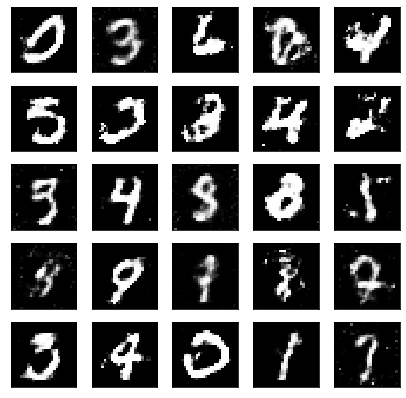

In [26]:
_ = view_samples(-1, samples) # 显示最后一轮的outputs

# 显示整个生成过程图片

In [27]:
# 指定要查看的轮次
epoch_idx = [0, 5, 10, 20, 40, 60, 80, 100, 150, 250] # 一共300轮，不要越界
show_imgs = []
for i in epoch_idx:
    show_imgs.append(samples[i][1])

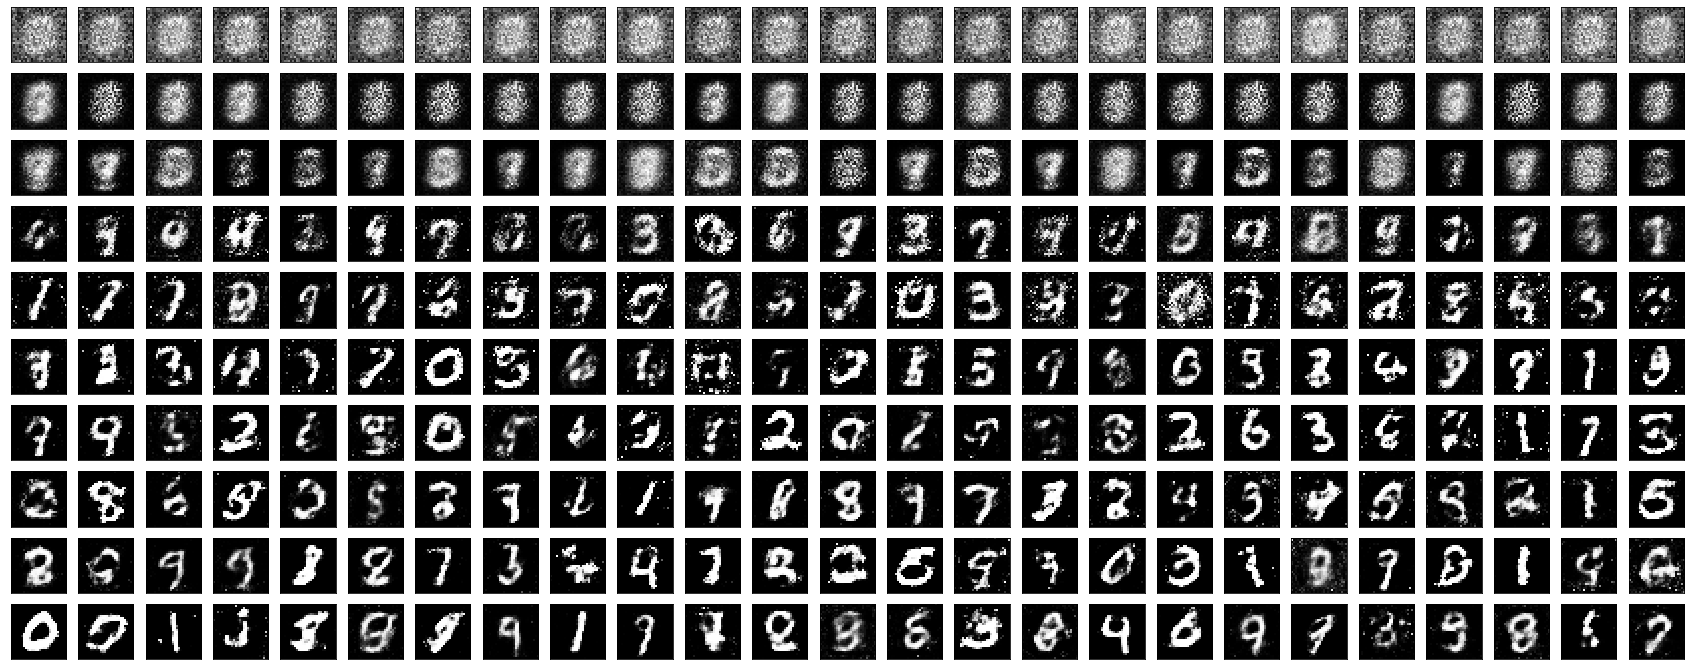

In [28]:
# 指定图片形状
rows, cols = 10, 25
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

idx = range(0, epochs, int(epochs/rows))

for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

# 生成新的图片

In [29]:
# 加载我们的生成器变量
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_noise = np.random.uniform(-1, 1, size=(25, noise_size))
    gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                           feed_dict={noise_img: sample_noise})


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


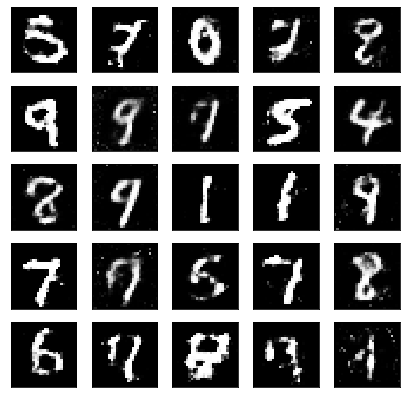

In [30]:
_ = view_samples(0, [gen_samples])